## Precision-Recall Curves

### Overview

This workbook explores the use of precision-recall curves to find appropriate threshold for applying a metadata tag to an uncategorized media type based on machine-learning based category probabilities.

### Method

We use a previously trained supervised classification model (Random Forest) based on human-assigned metadata category tages for digigal media based on transcriptions. Metadata tags include tobacco, opioid, health, legal, marketing, news report, youth.

With the exception of tobacco and opiod (which are assigned based on the original collection source for the document), none of these tags appear in more than 10% of the documents. As a result, we are dealing with an imbalanced binary classification model, where the inclusion of a tag would occur only 10% of the time. Because of this, a model that suggests a probability of positive classification of 20% may indicate that we should include the tag in search results. 

The harm of false positives or negatives depends heavily on the research or use scenario. For example, a researcher who wants to retrieve all resonably positive matches and is not concerned with the inclusion of a few documents that are not related to litigation might want to set the threshold very low, even below 10%. Alternatively, a researcher might simply wish to sample a small number of litigation-related documents with a very high level of accuracy. In this case, a high threshold would be more beneficial.
|
### Technical Considerations

Because our initial dataset is small (only 300 human reviewed records are available for supervised classification), and many of the tags only show up in 10% of the records, we limit our initial analysis to a small set of metadata tags. Because these tags are human-generated and did not conform to a limited and controlled vocabulary, there is inconsistency in the training data as well. Some tags are redundant, always (or nearly always) showing up in clusters (legal and litigation, for instance, have a 95%+ overlap). Other times, two categories that might be better approached as a single category cause a split that may greatly reduce the effectiveness of an ML based classifier. Human ambiguity is often amplified when used to train ML models, and we see that effect at work here.

### Precision-Recall Curves.

Because there is a class imbalance between positive and negative categorization (including vs excluding a tag) and false positives are unlikely to be a serious problem (though, as discussed above, there may be some scenarios, such as sampling, where we would want to avoid them), we'll take a look at precision-recall curves for a few of the more commonly occuring tabs. 

__ provides a good overview for Precision-Recall curves:

For quick reference, *Precision* refers to how often a positive classification was correct. For example, if our model predicted that a "Legal" tag should apply to record correctly 9 times and incorrectly 1 time, the Precision would be 90%. *Recall* refers to how often a positive classification was accurately detected. For example, if 10 records should have been classified as Legal, and our model detected 8 of them, our recall rate would be 80%. Ideally, we would like to strike some kind of balance between these two metrics, something we can achieve by raising or lowering the probability threshold for including a record in a tag. For example, if our model assigned a 30% change that a particular record should be classified as "Legal", we might or might not set that assignment based on whether we are trying to improve precision or recall. 

### Workbook

This workbook uses the scikit-plot module from scikit-learn to generate a precison-recall curves for a tag used in the classification model. Keep in mind that there isn't much benefit to analyzing tags that show up in less than 10% of the records, and some tags may result in an error, as positive observations may be so rare (fewer than 1-2% of the records) that there is insufficient data to train or apply an ML model (a random test/train split may have *no* observations for a rare tag such a small dataset). 

### Visualization and Interpretation

This section displays the PR curve for "Legal", a tag that shows up in approximately 10% of the training records. Keep in mind that common tags like "Tobacco", which show up in 90% of the records, are auto-assigned based on the source of the collection, and do not represent the common use case. 

#### Precision-Recall

The precision recall curve for Legal indicates a wide threshold range that preserves usable precision and recall levels. Very high or low thresholds cause degradation of model performace, but precision and recall above 80% are available with flexibility to optimize for one or the other

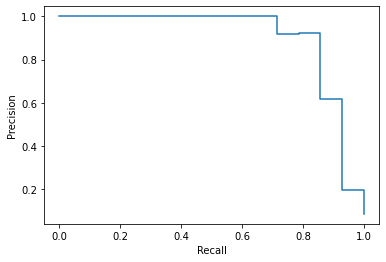

#### Precision/Recall-Threshold

This chart plots both precision and recall curves on the Y axis with the threshold level on the X axis. We see a rapid improvement of precision with a gradual, near-linear decrease in recall, indicating an effective threshold range well below 50%. 

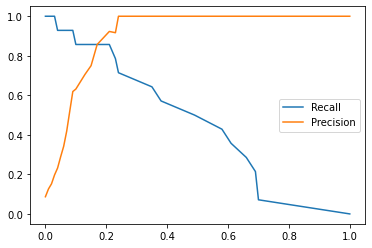

### Production Application

Although our current data set is small, initial results suggest that there is some value in using a a supervised classification model to extend metata to uncategorized documents based on ML generated transcript. 

Integrating these techniques into production would involve a number of decisions that are outside the scope of this pilot. Different research objectives may require different thresholds, and with 1.7 million documents in the archive (many without transcripts), it may not be realistic to provide researchers with a way to set a custom threshold that performs reasonably within time constraints and can be integrated into the existing UI and application architecture. A more promising route might be to include probability estimates relative to tag frequency in auto-generated research-generated data sets. Lastly, all of this depends on the availability of transcriptions for video and audio related documents, an expensive and time consuming proposition that may not be available for some time. And once those transcriptions are available and indexed, a general term search with document relevance ranking may be more valuable than an ML-based supervised classification score. 

### Conclusion

This pilot provides a template for an interesting and promising approach, and researchers may be interested in building their own ML models to analyze the transcript data. However, all this work is dependent on the availability of meaningful transcriptions. For now, priority should be on generating and updating transcription datasets for researchers based on recent improvements in AI-based transcription technology. 

In [1]:
#!pip install scikit-plot

In [2]:
import pandas as pd
from pandasql import sqldf
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
import nltk
from nltk.corpus import stopwords
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay

In [3]:
stop = stopwords.words('english')

In [4]:
pd.set_option('display.max_colwidth', 70)
pd.set_option('display.max_rows', None)

In [5]:
pysqldf = lambda q: sqldf(q, globals())

In [6]:
# setting a couple of workbook variables
text_source = "transcript"
tag = "legal"

In [7]:
df_human = pd.read_csv("data/classifications.csv")
df_ml = pd.read_csv("data/transcript_accuracy.csv")

In [8]:
df_dataset = pysqldf(f"""
SELECT dh.*, dml.{text_source}, dml.`avg(confidence)` as avg_confidence
FROM 
    df_human dh
JOIN
    df_ml dml
ON dh.ID = dml.id
    WHERE description is not NULL
    AND description != 'error code 224003'
    AND subject NOT LIKE '%href%'
""")

In [9]:
df = pysqldf(f"""
SELECT 
    ID,
    subject,  
    {text_source},
    avg_confidence,
    CASE
        WHEN subject LIKE '%{tag}%' THEN 1
        ELSE 0
    END AS category
FROM df_dataset
""")

In [10]:
df.set_index("ID", inplace=True)

In [11]:
df_train, df_test = train_test_split(df, test_size=0.5)

In [12]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words=stop)),
    ('clf', RandomForestClassifier())
    ])

In [13]:
X_train = text_clf['vect'].fit_transform(df_train[text_source])

In [14]:
pd.set_option('display.max_rows', None)

In [15]:
X_train = text_clf.fit(df_train[text_source], df_train['category'])

In [16]:
feature_df = pd.DataFrame({"feature": text_clf['vect'].get_feature_names_out(), 
                           'importance': text_clf['clf'].feature_importances_})

In [17]:
y_proba = text_clf.predict_proba(df_test[text_source])
y_true = df_test['category']

In [18]:
y_pred = [y_proba[i][1] for i in range(len(y_proba))]

In [19]:
import numpy as np
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
precision = list(precision)
recall = list(recall)
thresholds = list(thresholds) + [1]

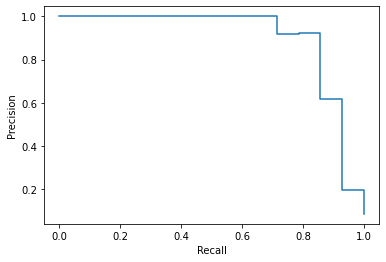

In [20]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

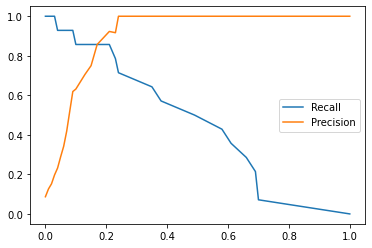

In [21]:
import matplotlib.pyplot as plt
import numpy as np

xticks = thresholds
plt.plot(thresholds, list(recall), label="Recall")
plt.plot(thresholds, list(precision), label="Precision")
leg = plt.legend()
plt.show()

In [22]:
df = pd.DataFrame({'threshold':thresholds, 'precision':precision, 'recall':recall})